### Statistical Validation — Bootstrap & Significance Testing

This notebook validates whether observed uplift is statistically significant.


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

orders = pd.read_csv("../data/processed/orders_enriched.csv", parse_dates=["InvoiceDate"])
customers = pd.read_csv("../data/processed/customers_growth_metrics.csv")


Prepare post-period data

In [33]:
# A/B Test Rigor
post_orders = (
    orders
    .merge(customers, on="CustomerID")
    .query("period == 'post'")
)

treatment = post_orders.loc[
    post_orders["experiment_group"] == "treatment", "order_gmv"
]

control = post_orders.loc[
    post_orders["experiment_group"] == "control", "order_gmv"
]

Sanity check for distribution

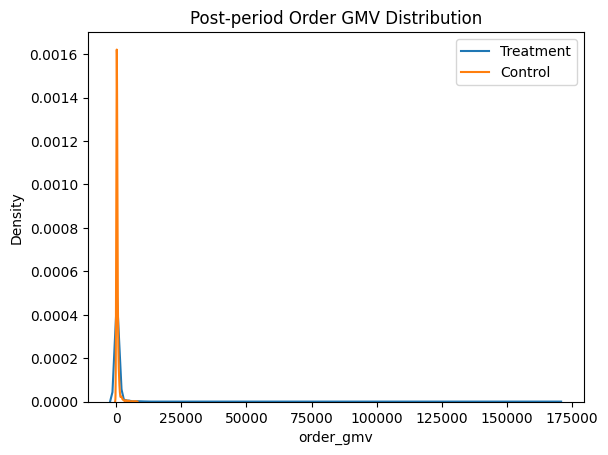

In [34]:
sns.kdeplot(treatment, label="Treatment")
sns.kdeplot(control, label="Control")
plt.title("Post-period Order GMV Distribution")
plt.legend()
plt.show()


Bootstrap test

In [35]:
def bootstrap_diff(treatment, control, n=10000):
    diffs = []
    for _ in range(n):
        t_sample = np.random.choice(treatment, size=len(treatment), replace=True)
        c_sample = np.random.choice(control, size=len(control), replace=True)
        diffs.append(t_sample.mean() - c_sample.mean())
    return np.array(diffs)

diffs = bootstrap_diff(treatment.values, control.values)

In [36]:
# Confidence interval
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
mean_diff = diffs.mean()

ci_lower, ci_upper, mean_diff


(1.8523645924316963, 281.56295297310197, 109.47867043838454)

t-test

In [37]:
#t-test with caveats
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(treatment, control, equal_var=False)
t_stat, p_value

(1.460522307033352, 0.14427235401272726)